# Capstone Project – Covid-19 Classification Dataset - Transition to Modeling

This file/notebook continues from the EDA notebook for Covid-19 Classification dataset.  This covers, preprocessing, training multiple models, and comparing performance.

## Table of Contents
1. [10. Data Preprocessing](#10.-Data-Preprocessing)
   - [10.1 Libraries and Load Dataset](#10.1-Libraries-and-Load-Dataset)
   - [10.2 Data Quality Checks](#10.2-Data-Quality-Checks)
   - [10.3 Features and Target Seperation](#10.3-Features-and-Target-Seperation)
   - [10.4 Identify Numerical vs Categorical Features](#10.4-Identify-Numerical-vs-Categorical-Features)
   - [10.5 Train-Test Split](#10.5-Train-Test-Split)
   - [10.6 Simple Preprocessing (Impute + Scale)](#10.6-Simple-Preprocessing-(Impute-+-Scale))
   - [10.7 Feature Selection (Simple)](#10.7-Feature-Selection-(Simple))
2. [11. Model Building and Evaluation](#11.-Mmodel-Building-and-Evaluation)
   - [11.1 Imports](#11.1-Imports)
   - [11.2 Train and Evaluate Models](#11.2-Train-and-Evaluate-Models)
   - [11.3 Compare Model Performance](#11.3-Compare-Model-Performance)
   - [11.4 Confusion Matrices](#11.4-Confusion-Matrices)
   - [11.5 Model Selection Summary](#11.5-Model-Selection-Summary)
   - [11.6 Export Best Model Predictions for Tableau](#11.6-Export-Best-Model-Predictions-for-Tableau)


## 10. Data Preprocessing

Goal: create a clean, model-ready train/test dataset

### 10.1 Libraries and Load Dataset

In [1]:
from pathlib import Path

# Get project root (parent of notebooks folder)
PROJECT_ROOT = Path.cwd().parent

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
DATA_FILE = "covid19_classification_dataset.csv"

DATA_PATH = DATA_DIR / DATA_FILE

OUTPUT_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at '{DATA_PATH}'.\n"
        "Please ensure the dataset is placed inside the 'data' folder at the project root."
    )

print("Project paths configured successfully.")
#print(f"Data path: {DATA_PATH}")
#print(f"Output directory: {OUTPUT_DIR}")

import pandas as pd
# Load the dataset into a DataFrame
df = pd.read_csv(DATA_PATH)

# Display dataset shape and preview the first few rows
print("Dataset shape:", df.shape)
df.head()


Project paths configured successfully.
Dataset shape: (25000, 40)


,Age,Gender,Body_Temperature,Heart_Rate,Blood_Pressure,Respiratory_Rate,Oxygen_Saturation,WBC_Count,RBC_Count,Hemoglobin,...,Vaccination_Status,Antibody_Test_Result,PCR_Test_Result,CT_Scan_Result,Hospital_Visit,ICU_Admission,Ventilator_Support,Medication1,Medication2,Infected
0,13,1,35.134099,81,147,0.523761,0.302747,0.123436,0.658795,0.012816,...,0.846561,0.412137,0.436994,0.364177,0.069888,0.904606,0.651761,0.039014,0.843462,1
1,76,1,35.580493,90,130,0.966758,0.003206,0.168959,0.405961,0.333612,...,0.952789,0.918433,0.832046,0.402552,0.568562,0.797441,0.390942,0.943742,0.008779,1
2,93,1,36.924017,95,138,0.957638,0.322076,0.505236,0.819760,0.098995,...,0.687951,0.757119,0.664940,0.857466,0.169404,0.755714,0.753113,0.322734,0.100451,0
3,63,0,NaN,72,164,0.083596,0.335388,0.872939,0.963631,0.797913,...,0.736746,0.199022,0.021751,0.288700,0.131783,0.068656,0.865557,0.680145,0.722547,1
4,88,1,NaN,60,160,0.394405,0.240267,0.599968,0.470137,0.863037,...,0.882584,0.948702,0.183534,0.996122,0.297384,0.210018,0.598593,0.222116,0.882834,1


[**GO TO - Table of Contents**](#Table-of-Contents)

# Modeling Assumptions and Evaluation Plan

- This is a **binary classification** problem (predict "Infected": 0 or 1).
- Use a **train-test split** and keep the split reproducible using a fixed "random_state".
- Use "stratify=y" during splitting to keep the **same class balance** in both training and test sets.
- **Preprocessing is fit only on the training set** (median/mode and scaling) and then applied to the test set to avoid data leakage.
- Evaluate models using **Accuracy, Precision, Recall, and F1-score**.
- Because healthcare decisions care about both false positives and false negatives, **F1-score** is used as a strong overall comparison metric.


### 10.2 Data Quality Checks

In [2]:
# Perform basic data quality checks

# Check for duplicate rows in the dataset
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# Remove duplicate rows and reset the index
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", df.shape)

# Check for missing values in each column
# isna().sum() counts missing values per column
missing_values = df.isna().sum()

# Keep only columns that have missing values and sort them
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("\nMissing values per column:")
display(missing_values)

# Display total number of missing values in the dataset
print("\nTotal missing values:", df.isna().sum().sum())


Number of duplicate rows: 10
Shape after dropping duplicates: (24990, 40)

Missing values per column:


Fatigue             7
Loss_of_Smell       5
Body_Temperature    5
RBC_Count           4
Respiratory_Rate    4
Cough               3
Sore_Throat         2
dtype: int64


Total missing values: 30


[**GO TO - Table of Contents**](#Table-of-Contents)

### 10.3 Features and Target Seperation

In [3]:
# Define features and target variable

# Specify the target column
TARGET_COL = "Infected"

# Separate features (X) and target (y)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Display shapes and target distribution
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Target value counts:")
display(y.value_counts())


X shape: (24990, 39)
y shape: (24990,)
Target value counts:


Infected
1    12540
0    12450
Name: count, dtype: int64

### 10.4 Identify Numerical vs Categorical Features

In [4]:
# Identify numerical and categorical features

# Select numeric columns based on data types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Identify remaining columns as categorical or binary
cat_cols = [c for c in X.columns if c not in numeric_cols]

# Display counts and sample column names
print("Numeric columns:", len(numeric_cols))
print(numeric_cols)

print("Categorical / binary columns:", len(cat_cols))
print(cat_cols[:20])


Numeric columns: 39
['Age', 'Gender', 'Body_Temperature', 'Heart_Rate', 'Blood_Pressure', 'Respiratory_Rate', 'Oxygen_Saturation', 'WBC_Count', 'RBC_Count', 'Hemoglobin', 'Platelets', 'Lymphocytes', 'Neutrophils', 'Cough', 'Fever', 'Fatigue', 'Headache', 'Sore_Throat', 'Loss_of_Smell', 'Loss_of_Taste', 'Nausea', 'Vomiting', 'Diarrhea', 'Muscle_Pain', 'Shortness_of_Breath', 'Chest_Pain', 'Pre_existing_Condition1', 'Pre_existing_Condition2', 'Travel_History', 'Contact_with_Infected', 'Vaccination_Status', 'Antibody_Test_Result', 'PCR_Test_Result', 'CT_Scan_Result', 'Hospital_Visit', 'ICU_Admission', 'Ventilator_Support', 'Medication1', 'Medication2']
Categorical / binary columns: 0
[]


[**GO TO - Table of Contents**](#Table-of-Contents)

### 10.5 Train-Test Split

In [5]:
# Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split

# stratify=y keeps the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Display the size of training and test sets
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (19992, 39)
Test set: (4998, 39)


### 10.6 Simple Preprocessing (Impute + Scale)

We will perform:
1) Fill missing numeric values with the **median** (using training data median).
2) Fill missing categorical/binary values with the **mode** (most common value in training data).
3) Standardize numeric columns using **StandardScaler** (fit on training only).

In [6]:
# Simple preprocessing: imputation and scaling
from sklearn.preprocessing import StandardScaler
# Make copies so the original train and test sets remain unchanged
X_train_p = X_train.copy()
X_test_p = X_test.copy()

# 1) Impute numeric columns using the median from the training set
# Median is robust to outliers
for col in numeric_cols:
    med = X_train_p[col].median()
    X_train_p[col] = X_train_p[col].fillna(med)
    X_test_p[col] = X_test_p[col].fillna(med)

# 2) Impute categorical / binary columns using the mode from the training set
# Mode represents the most frequent value
for col in cat_cols:
    # Check if the column has missing values
    if X_train_p[col].isna().any():
        # mode() may return multiple values; select the first one
        mode_val = X_train_p[col].mode(dropna=True)
        mode_val = mode_val.iloc[0] if len(mode_val) > 0 else 0

        X_train_p[col] = X_train_p[col].fillna(mode_val)
        X_test_p[col] = X_test_p[col].fillna(mode_val)

# 3) Scale numeric columns
# StandardScaler standardizes features to mean 0 and standard deviation 1
scaler = StandardScaler()
X_train_p[numeric_cols] = scaler.fit_transform(X_train_p[numeric_cols])
X_test_p[numeric_cols] = scaler.transform(X_test_p[numeric_cols])

# Confirm preprocessing completion and dataset shapes
print("Preprocessing done.")
print("X_train_p shape:", X_train_p.shape)
print("X_test_p shape:", X_test_p.shape)

# Preview the processed training data
X_train_p.head()


Preprocessing done.
X_train_p shape: (19992, 39)
X_test_p shape: (4998, 39)


,Age,Gender,Body_Temperature,Heart_Rate,Blood_Pressure,Respiratory_Rate,Oxygen_Saturation,WBC_Count,RBC_Count,Hemoglobin,...,Contact_with_Infected,Vaccination_Status,Antibody_Test_Result,PCR_Test_Result,CT_Scan_Result,Hospital_Visit,ICU_Admission,Ventilator_Support,Medication1,Medication2
13646,-1.681303,1.011268,-0.779276,1.600380,-1.297249,1.290527,-0.199228,-1.122992,0.284929,0.056387,...,-1.309237,1.108617,0.217663,-0.696182,-0.377807,-0.940377,0.290247,1.202152,0.468451,1.337477
1217,0.231075,-0.988858,-1.859867,-1.431358,-1.331910,-0.806984,0.936915,-1.621208,0.807332,1.280325,...,-0.122182,-1.058681,1.585856,-0.708615,1.686871,0.806078,0.676548,1.676539,-0.067033,0.078687
4372,-1.368369,-0.988858,0.560567,-0.132042,1.094321,-0.686758,-1.734116,1.551167,-1.520613,-1.634035,...,1.048822,0.951516,0.273459,-0.588696,1.514427,1.460144,-0.080476,0.812767,1.435080,-0.484117
20249,-0.568647,1.011268,0.506656,0.907411,0.574415,1.053209,-0.705776,1.218244,1.573559,-1.567946,...,-1.267421,-0.327020,1.270980,0.199026,-0.144722,1.029579,-1.573520,-0.786802,1.497548,-0.850474
11357,-1.159746,1.011268,-0.133036,-0.305284,-1.262589,-0.371886,-0.624511,1.167130,0.366893,-1.142063,...,1.364951,-0.738679,-0.713390,-0.611865,0.178585,-0.810211,0.712458,-1.044814,1.293065,0.423814


[**GO TO - Table of Contents**](#Table-of-Contents)

### 10.7 Feature Selection (Simple)
Before training models, we need to understand which features are most important.
We use **Random Forest feature importance** because it is simple and works well for mixed feature types.

What we will get:
- A ranked list of top features
- A bar chart for the **Top 10**


Top 10 important features:


Travel_History           0.027099
Body_Temperature         0.027061
ICU_Admission            0.026978
Platelets                0.026966
Headache                 0.026887
Fatigue                  0.026850
Medication2              0.026833
Contact_with_Infected    0.026826
Nausea                   0.026809
PCR_Test_Result          0.026743
dtype: float64

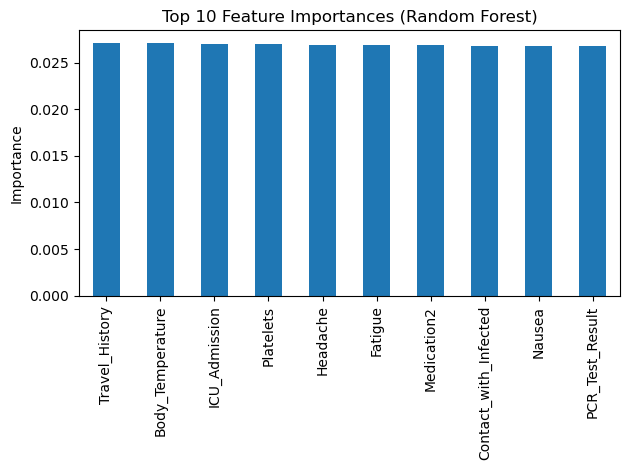

In [7]:
# Simple feature selection using Random Forest

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Random Forest classifier
rf_fs = RandomForestClassifier(
    n_estimators=200,   # Number of decision trees in the forest
    random_state=42,    # Ensures reproducible results
    n_jobs=-1           # Uses all available CPU cores for faster training
)

# Fit the model on the preprocessed training data
rf_fs.fit(X_train_p, y_train)

# Extract feature importance scores
# The "feature_importances_" indicates how much each feature contributes to the model
importances = pd.Series(
    rf_fs.feature_importances_,
    index=X_train_p.columns
)

# Select the top 10 most important features
top10 = importances.sort_values(ascending=False).head(10)

# Display the top 10 features
print("Top 10 important features:")
display(top10)

# Plot the feature importance values
plt.figure()
top10.plot(kind="bar")

plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()

plt.show()



[**GO TO - Table of Contents**](#Table-of-Contents)

## 11. Model Building and Evaluation

We will train models one by one and store their test performance for comparison.

**Model Building and Evaluation:**

This section trains multiple classification models on the preprocessed dataset and evaluates their performance using:
- Accuracy
- Precision
- Recall
- F1-score

Models trained:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)


### 11.1 Imports

In [8]:
# 11.1 Imports

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

### 11.2 Train and Evaluate Models



In [9]:
# Import classification models

from sklearn.linear_model import LogisticRegression      # Linear model for binary classification
from sklearn.tree import DecisionTreeClassifier           # Tree-based classification model
from sklearn.ensemble import RandomForestClassifier       # Ensemble of decision trees
from sklearn.svm import SVC                               # Support Vector Machine classifier

# Import evaluation metrics
from sklearn.metrics import (
    accuracy_score,        # Overall correctness of the model
    precision_score,       # How many predicted positives are actually positive
    recall_score,          # How many actual positives are correctly identified
    f1_score,              # Balance between precision and recall
    confusion_matrix,      # Table showing correct vs incorrect predictions
    classification_report  # Detailed metrics summary per class
)


In [10]:
# Model 1: Logistic Regression
# Logistic Regression is used as a baseline classification model

# Initialize a dictionary to store all model results
results = {}

# Define the evaluation function
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ConfusionMatrix": cm,
        "Pred": y_pred  # Store predictions for later export
    }

# Initialize Logistic Regression model
lr = LogisticRegression(
    max_iter=1000,   # Maximum number of iterations for model convergence
    random_state=42 # Ensures reproducible results
)

# Train the model on the preprocessed training data
lr.fit(X_train_p, y_train)

# Evaluate the model on the test data and store results
results["Logistic Regression"] = evaluate(lr, X_test_p, y_test)

# Display key evaluation metrics
print("Logistic Regression metrics:")
print({
    k: round(v, 4)
    for k, v in results["Logistic Regression"].items()
    if k in ["Accuracy", "Precision", "Recall", "F1"]
})

Logistic Regression metrics:
{'Accuracy': 0.5016, 'Precision': 0.5033, 'Recall': 0.5195, 'F1': 0.5113}


[**GO TO - Table of Contents**](#Table-of-Contents)

Decision Tree metrics:
{'Accuracy': 0.5052, 'Precision': 0.507, 'Recall': 0.502, 'F1': 0.5045}


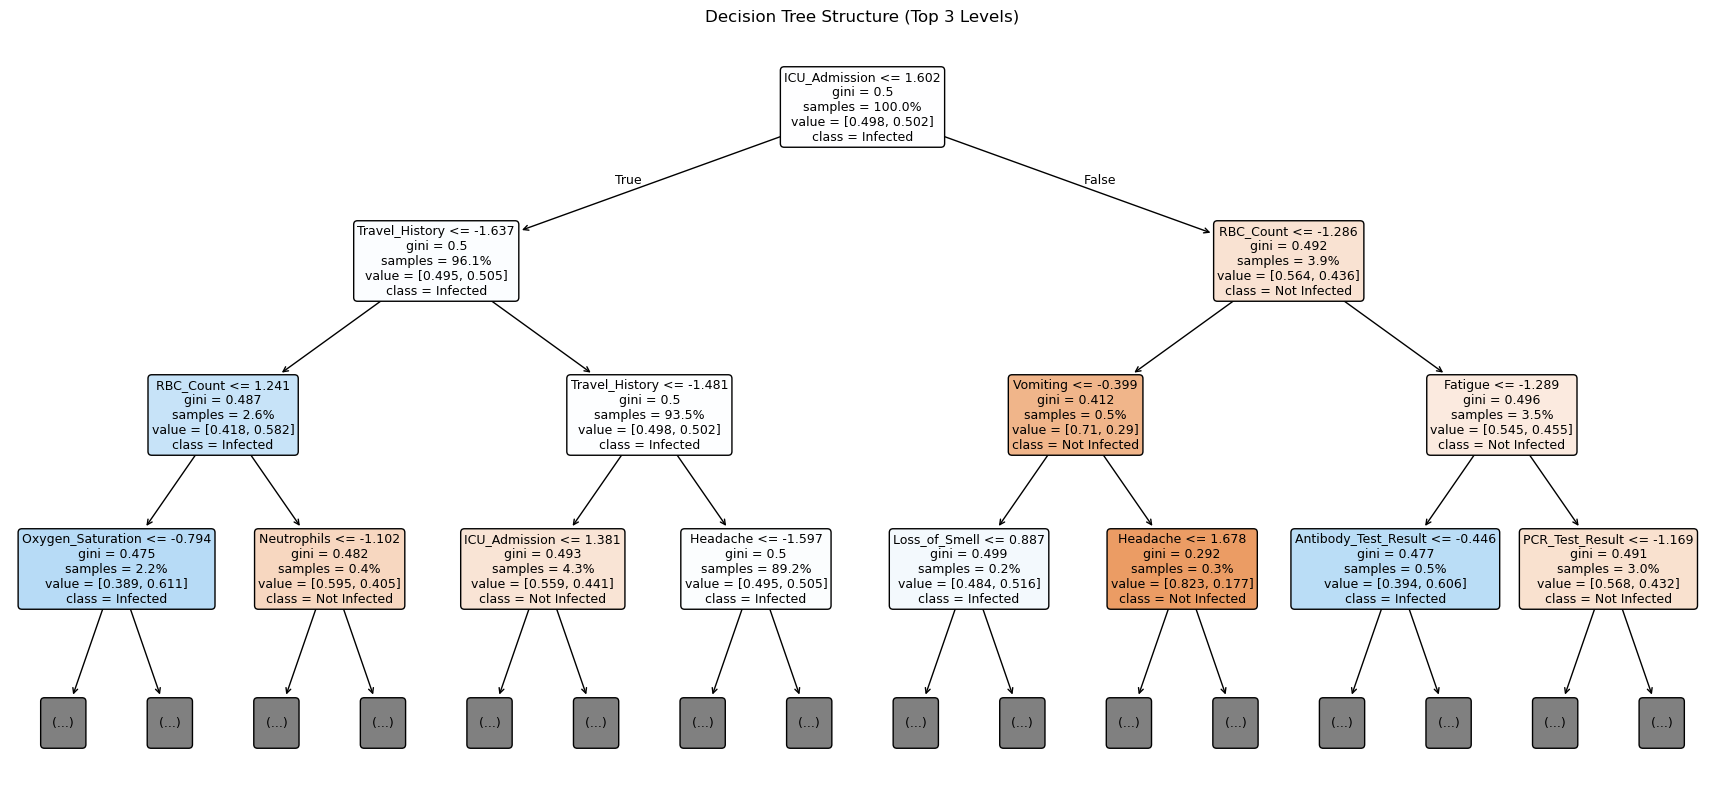

In [11]:
# Model 2: Decision Tree
# Decision Trees will capture non-linear relationships and are easy to interpret

from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(
    random_state=42
)

# Train the model using preprocessed training data
dt.fit(X_train_p, y_train)

# Evaluate the model on the test data and store results
results["Decision Tree"] = evaluate(dt, X_test_p, y_test)

# Display key evaluation metrics
print("Decision Tree metrics:")
print({
    k: round(v, 4)
    for k, v in results["Decision Tree"].items()
    if k in ["Accuracy", "Precision", "Recall", "F1"]
})


# Visualize the Decision Tree structure.  Limited to the first few levels to keep it readable.
plt.figure(figsize=(22, 10))

plot_tree(
    dt,
    feature_names=X_train_p.columns if hasattr(X_train_p, "columns") else None,
    class_names=["Not Infected", "Infected"],
    filled=True,            # Color nodes by class purity
    rounded=True,           # Rounded node boxes for clarity
    proportion=True,        # Show class proportions instead of raw counts
    max_depth=3,            # Display only top levels for interpretability
    fontsize=9
)

plt.title("Decision Tree Structure (Top 3 Levels)")
plt.show()

[**GO TO - Table of Contents**](#Table-of-Contents)

Random Forest metrics:
{'Accuracy': 0.5014, 'Precision': 0.5032, 'Recall': 0.508, 'F1': 0.5056}


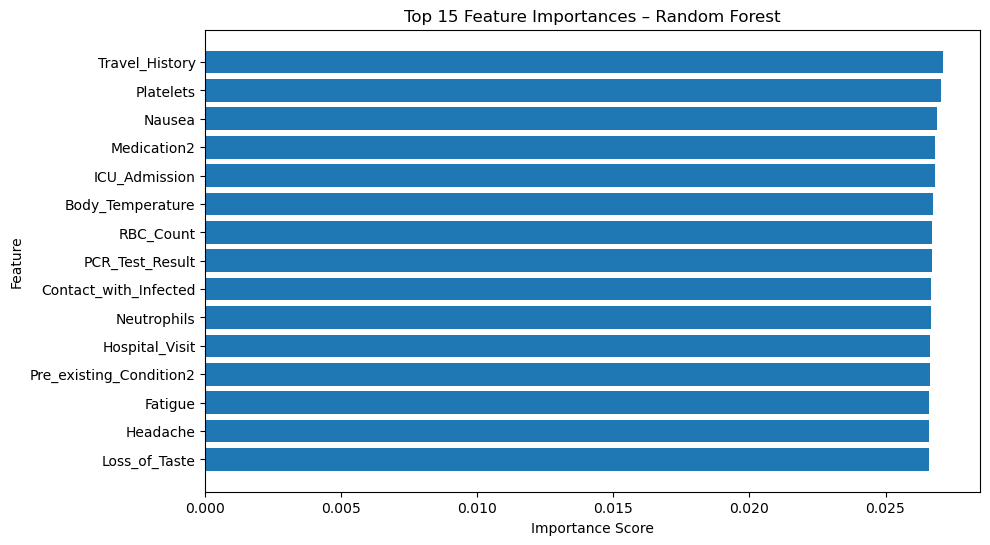

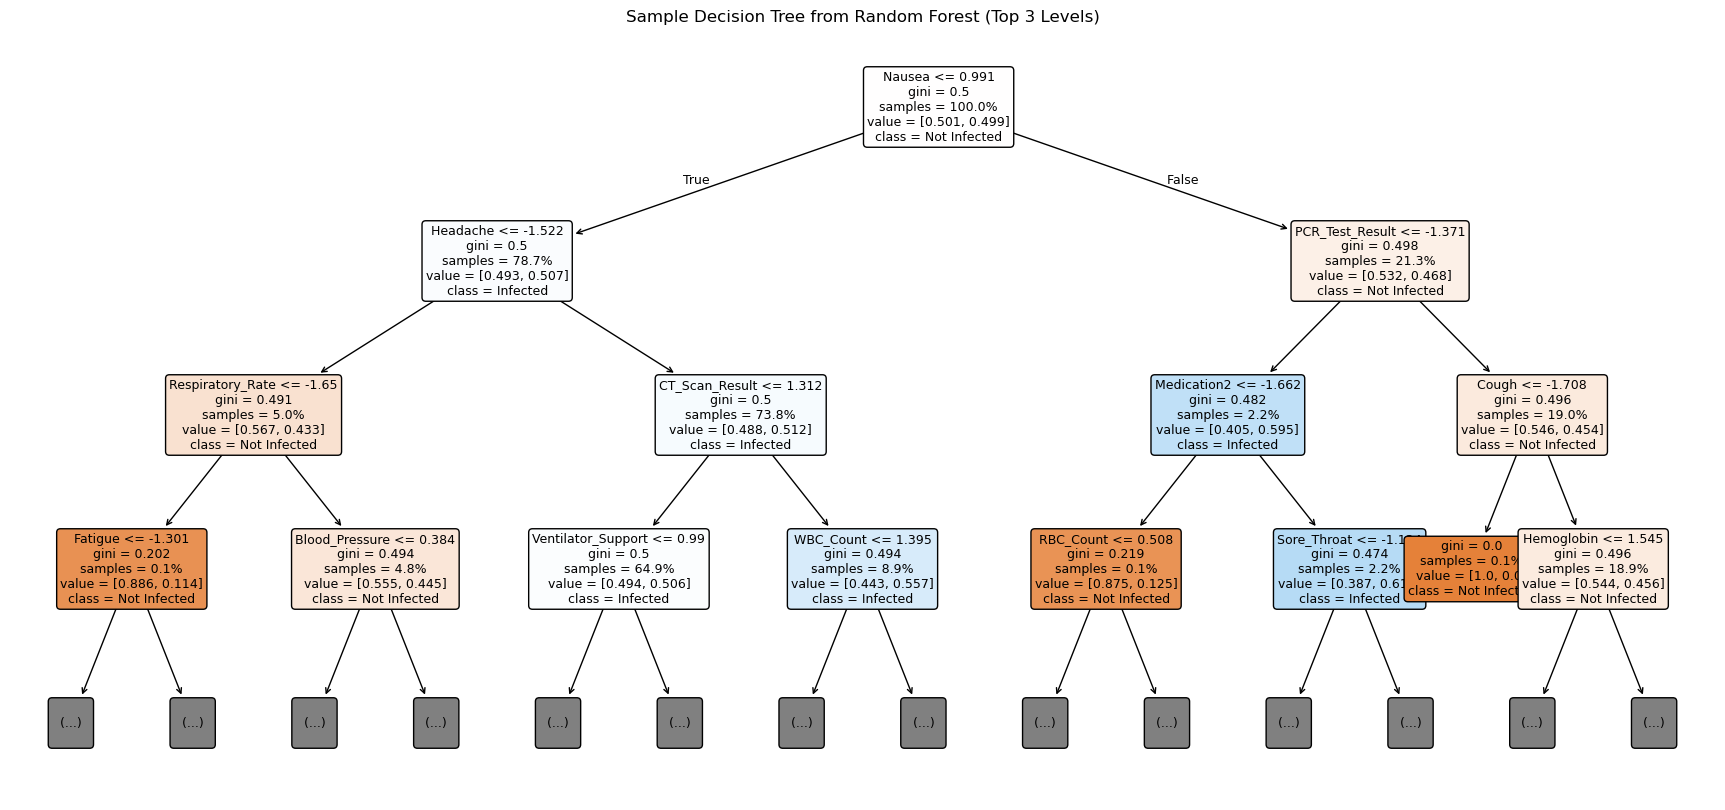

In [12]:
# Model 3: Random Forest Classification 
# Random Forest is an ensemble model that combines multiple decision trees to improve predictive performance and reduce overfitting.

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Initialize the Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=300,   # Number of trees in the forest
    random_state=42,    # Ensures reproducible results
    n_jobs=-1           # Use all CPU cores for faster training
)

# Train the model using preprocessed training data
rf.fit(X_train_p, y_train)

# Evaluate the model on test data
results["Random Forest"] = evaluate(rf, X_test_p, y_test)

# Display key evaluation metrics
print("Random Forest metrics:")
print({
    k: round(v, 4)
    for k, v in results["Random Forest"].items()
    if k in ["Accuracy", "Precision", "Recall", "F1"]
})

# Visualize Feature Importances
importances = rf.feature_importances_

feature_names = (
    X_train_p.columns if hasattr(X_train_p, "columns")
    else [f"Feature {i}" for i in range(len(importances))]
)

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi_df["Feature"][:15], fi_df["Importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# A Random Forest consists of many trees. Visualizing one representative tree helps understand the type of splits learned by the ensemble.

sample_tree = rf.estimators_[0]

plt.figure(figsize=(22, 10))
plot_tree(
    sample_tree,
    feature_names=feature_names,
    class_names=["Not Infected", "Infected"],
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=3,
    fontsize=9
)

plt.title("Sample Decision Tree from Random Forest (Top 3 Levels)")
plt.show()


[**GO TO - Table of Contents**](#Table-of-Contents)

In [13]:
# Model 4: Support Vector Machine (RBF Kernel)
# SVM with RBF kernel handles non-linear decision boundaries
# A Support Vector Machine (SVM) is a supervised machine-learning algorithm used mainly for classification and sometimes regression.
# SVM main goal is to find the best boundary that separates classes with the maximum margin.
# (i) The boundary is called a hyperplane. (ii) The closest data points to that boundary are called support vectors
# (iii) SVM focuses only on those critical points, not all data points

# Initialize SVM classifier
svm = SVC(
    kernel="rbf",      # Radial Basis Function kernel for non-linear separation
    random_state=42    # Ensures reproducible results
)

# Train the model on the preprocessed training data
svm.fit(X_train_p, y_train)

# Evaluate the model on the test data and store results
results["SVM (RBF)"] = evaluate(svm, X_test_p, y_test)

# Display key evaluation metrics
print("SVM (RBF) metrics:")
print({
    k: round(v, 4)
    for k, v in results["SVM (RBF)"].items()
    if k in ["Accuracy", "Precision", "Recall", "F1"]
})



SVM (RBF) metrics:
{'Accuracy': 0.5056, 'Precision': 0.5072, 'Recall': 0.5175, 'F1': 0.5123}


[**GO TO - Table of Contents**](#Table-of-Contents)

### 11.3 Compare Model Performance

In [14]:
# Compare performance metrics across all models

# Create a comparison table using results from each model
compare_df = pd.DataFrame({
    name: {
        "Accuracy": res["Accuracy"],
        "Precision": res["Precision"],
        "Recall": res["Recall"],
        "F1": res["F1"],
    }
    for name, res in results.items()
}).T

# Round values and sort models by F1-score
compare_df = compare_df.round(4).sort_values(by="F1", ascending=False)

# Display the comparison table
compare_df


,Accuracy,Precision,Recall,F1
SVM (RBF),0.5056,0.5072,0.5175,0.5123
Logistic Regression,0.5016,0.5033,0.5195,0.5113
Random Forest,0.5014,0.5032,0.5080,0.5056
Decision Tree,0.5052,0.5070,0.5020,0.5045


[**GO TO - Table of Contents**](#Table-of-Contents)

ROC-AUC (Logistic Regression): 0.5059
ROC-AUC (SVM RBF): 0.5044


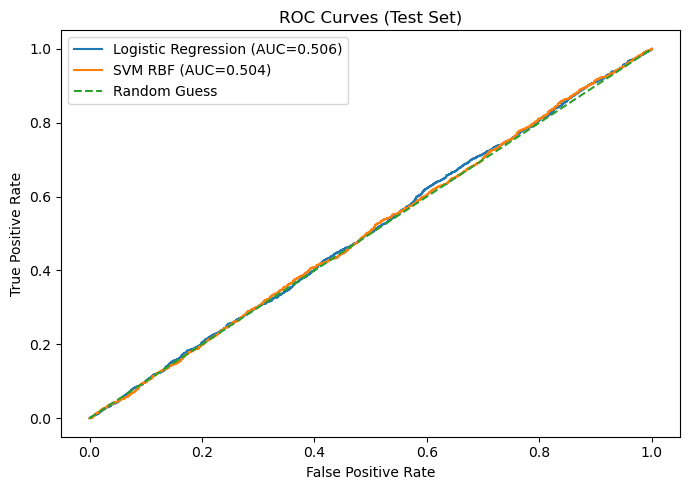

In [15]:
# ROC-AUC evaluation
# ROC: Receiver Operating Characteristic.
# ROC-AUC summarizes how well the model separates the two classes across different thresholds
# The ROC curve shows how well a classification model can distinguish between two classes (e.g., Infected vs Not Infected) across all possible thresholds.
# AUC is Area Under the ROC Curve. It summarizes the entire ROC curve into a single number.

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC-AUC for Logistic Regression and SVM
# - Logistic Regression provides probabilities using predict_proba()
# - SVM (without probability=True) provides scores using decision_function()

# Logistic Regression scores (probability of class 1)
lr_scores = lr.predict_proba(X_test_p)[:, 1]
lr_auc = roc_auc_score(y_test, lr_scores)

# SVM scores (distance to the separating boundary)
svm_scores = svm.decision_function(X_test_p)
svm_auc = roc_auc_score(y_test, svm_scores)

print(f"ROC-AUC (Logistic Regression): {lr_auc:.4f}")
print(f"ROC-AUC (SVM RBF): {svm_auc:.4f}")

# Plot ROC curves for a clear visual comparison
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_scores)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_scores)

plt.figure(figsize=(7, 5))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_auc:.3f})")
plt.plot(svm_fpr, svm_tpr, label=f"SVM RBF (AUC={svm_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.title("ROC Curves (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


[**GO TO - Table of Contents**](#Table-of-Contents)

### 11.4 Confusion Matrices (Heatmaps)

Confusion matrices show **what kinds of mistakes** each model makes (false positives vs false negatives).
Heatmaps make the results easier to read and include in your final report.

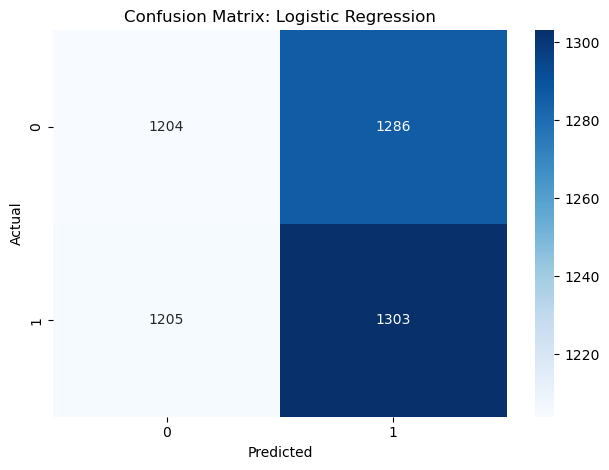

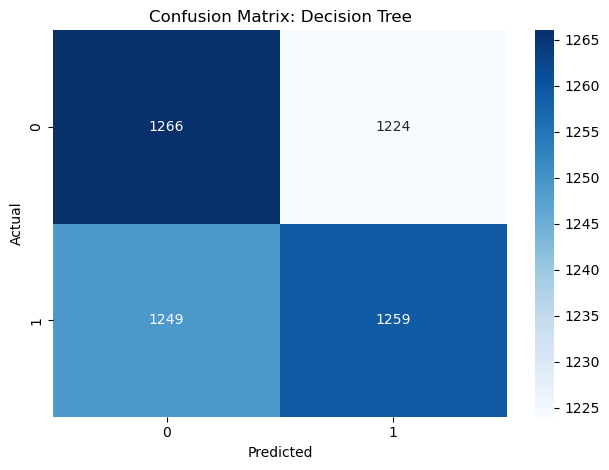

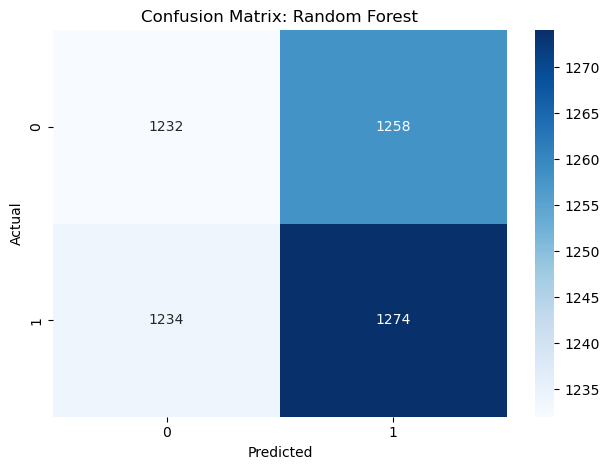

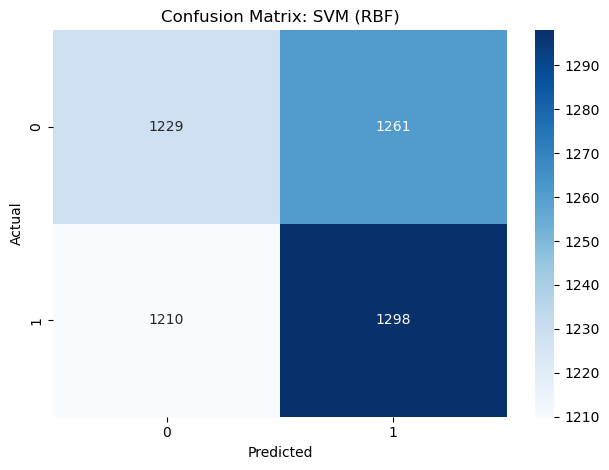

Saved Tableau-ready confusion matrix file: confusion_matrix_results.csv


,Model,Actual,Predicted,Count
0,Logistic Regression,0,0,1204
1,Logistic Regression,0,1,1286
2,Logistic Regression,1,0,1205
3,Logistic Regression,1,1,1303
4,Decision Tree,0,0,1266
5,Decision Tree,0,1,1224
6,Decision Tree,1,0,1249
7,Decision Tree,1,1,1259
8,Random Forest,0,0,1232
9,Random Forest,0,1,1258


In [16]:
# Plot confusion matrix heatmaps for each model
# Confusion matrices show correct and incorrect predictions
# Exported all confusion matrices to a Tableau-ready CSV for creating dashboard.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Collect confusion matrix cells for all models
confusion_rows = []

# Loop through each trained model and its results
for name, res in results.items():
    # Extract confusion matrix from evaluation results
    cm = res["ConfusionMatrix"] 

    # Store confusion matrix for Tableau
    confusion_rows.extend([
        {"Model": name, "Actual": 0, "Predicted": 0, "Count": int(cm[0][0])},  # TN
        {"Model": name, "Actual": 0, "Predicted": 1, "Count": int(cm[0][1])},  # FP
        {"Model": name, "Actual": 1, "Predicted": 0, "Count": int(cm[1][0])},  # FN
        {"Model": name, "Actual": 1, "Predicted": 1, "Count": int(cm[1][1])},  # TP
    ])

    plt.figure()

    # Plot confusion matrix as a heatmap
    # annot=True displays the values inside the cells
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Add titles and labels
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.tight_layout()
    plt.show()

# Create DataFrame and save to CSV for Tableau
confusion_df = pd.DataFrame(confusion_rows)
confusion_df.to_csv(OUTPUT_DIR /"confusion_matrix_results.csv", index=False)

print("Saved Tableau-ready confusion matrix file: confusion_matrix_results.csv")
display(confusion_df)



[**GO TO - Table of Contents**](#Table-of-Contents)

## 11.5 Model Selection Summary

Model Selection Summary:

The models were evaluated on the test set using Accuracy, Precision, Recall, and F1-score.

**Selection Criterion (recommended):**
- Since the classes are balanced, **F1-score** is a strong overall metric because it balances Precision and Recall.

The best-performing model is chosen as the one with the highest F1-score (and strong overall metrics).


**Model choice based on F1-score**

From the above table:

- SVM (RBF) has the highest F1-score (0.5123)
- Logistic Regression is a very close second
- Differences are small → important to acknowledge

[**GO TO - Table of Contents**](#Table-of-Contents)

## 11.6 Export Best Model Predictions for Tableau

We will pick the best model based on **F1-score** from the table above, then export test rows + predictions.

In [17]:
# Export predictions from the best-performing model for Tableau visualization

# Identify the best model based on highest F1-score
best_model_name = compare_df.index[0]
print("Best model (by F1):", best_model_name)

# Get predictions from the best model
best_pred = results[best_model_name]["Pred"]

# Create an export DataFrame using the original (unscaled) test features
# This makes the data easier to interpret in Tableau
export_df = X_test.copy()

# Add actual and predicted infection status
export_df["Infected_Actual"] = y_test.values
export_df["Infected_Pred"] = best_pred

# Indicate whether the prediction was correct (1 = correct, 0 = incorrect)
export_df["Correct_Prediction"] = (
    export_df["Infected_Actual"] == export_df["Infected_Pred"]
).astype(int)

# Save the results to a CSV file for Tableau
#export_path = "tableau_model_results.csv"

export_path = OUTPUT_DIR /"tableau_model_results.csv"
export_df.to_csv(export_path, index=False)
print("Saved:", export_path)

# Preview exported data and confirm shape
export_df.head()
export_df.shape


Best model (by F1): SVM (RBF)
Saved: C:\Users\rames\OneDrive\Desktop\SHEF Solutions_CAPSTONE Projects\COVID 19 Classification\outputs\tableau_model_results.csv


(4998, 42)

[**GO TO - Table of Contents**](#Table-of-Contents)

## ------------------------------------------------THANK YOU------------------------------------------------